In [44]:
import torch, torchaudio
from torch import nn
from torch.nn import functional as F

In [4]:
import pytorch_lightning as pl

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
torch.cuda.is_available()

False

## Step 1: loading the data

In [8]:
datapath = Path('data/ESC-50')

In [9]:
datapath.exists()

True

In [10]:
csv = pd.read_csv(datapath /  Path('meta/esc50.csv'))

In [11]:
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
len(csv)

In [14]:
x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0,0], normalize=True )

In [15]:
x.shape

torch.Size([1, 220500])

In [17]:
# useful as an hyperparameter to reduce training time
torchaudio.transforms.Resample(orig_freq=sr, new_freq=8000)(x).shape

torch.Size([1, 40000])

In [20]:
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

In [25]:
h.shape # 128 mel frequencies, 1103 is the time/frequencies

1103

In [23]:
h = torchaudio.transforms.AmplitudeToDB()(h)

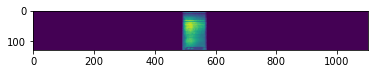

In [24]:
plt.imshow(h[0])

In [32]:
# everytime you want to work with data in Pytorch we need to use Dataset object
class ESC50Dataset(torch.utils.data.Dataset):
    
    # constructor
    def __init__(self, path: Path = Path('data/ESC-50'),
                sample_rate: int = 8000,
                folds = [1]):
        
        # Load CSV file & initialize all torchaudio.transforms
        # Resample --> Melspectrogram --> AmplitudeToDB

        self.path = path
        self.csv = pd.read_csv(datapath /  Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)]
        
        self.resample = torchaudio.transforms.Resample(orig_freq=44100, new_freq=sample_rate)
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)
        self.db = torchaudio.transforms.AmplitudeToDB()
        
    #function to index with [] square brackets
    def __getitem__(self, index):
        # Returns (xb, yb) pair
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename'])
        label = row['target']
        xb = self.db(
            self.melspec(
                self.resample(wav)
            )
        )
        return xb, label
    
    # function tells pytorch how many object you have in this object
    def __len__(self):
        return len(self.csv)

In [33]:
train_data = ESC50Dataset()

In [34]:
for xb, yb in train_data:
    break

In [35]:
xb.shape

torch.Size([1, 128, 201])

In [36]:
yb

0

In [38]:
train_data = ESC50Dataset(folds=[1])
val_data = ESC50Dataset(folds=[2])
test_data = ESC50Dataset(folds=[3])

In [50]:
# batch size has influence on convergence but also on memory
train_loader = \
    torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

In [51]:
# batch size has influence on convergence but also on memory
val_loader = \
    torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

In [52]:
# batch size has influence on convergence but also on memory
test_loader = \
    torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

## Building the model

In [56]:
class AudioNet(pl.LightningModule):
 
    def __init__(self, n_classes = 50, base_filters = 32): # or even 16 as base filters without GPU
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        # Logging to TensorBoard by default
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [58]:
pl.seed_everything(0) # always do it

Global seed set to 0


0

In [59]:
audionet = AudioNet()

In [60]:
xb, yb = next(iter(train_loader))

In [61]:
xb.shape

torch.Size([8, 1, 128, 201])

In [62]:
audionet(xb).shape

torch.Size([8, 50])

In [63]:
trainer = pl.Trainer(max_epochs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [64]:
trainer.fit(audionet, train_loader, val_loader)

/home/marco/anaconda3/envs/reprodl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 3.9 K 
1  | bn1   | BatchNorm2d | 64    
2  | conv2 | Conv2d      | 9.2 K 
3  | bn2   | BatchNorm2d | 64    
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 18.5 K
6  | bn3   | BatchNorm2d | 128   
7  | conv4 | Conv2d      | 73.9 K
8  | bn4   | BatchNorm2d | 256   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 6.5 K 
---------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.450     Total estimated model params size (MB)
/home/marco/anaconda3/envs/reprodl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, t

Training: 0it [00:00, ?it/s]

1

In [ ]:
trainer.test(audionet, test_loader)